In [45]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp
import pandas as pd

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    #location = 'E:\\Documents\\Dan\\Code\\Prospectus\\Document\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    location = 'E:\\Documents\\Dan\\Phd\\Play\\'

#Standard cycle for collors and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [46]:
#Extra Headers:
import os as os
import statistics as st
import os as os
import pandas as pd
import random
import multiprocessing
from joblib import Parallel, delayed
import time

In [47]:
#Columns names for a file with all 6 dimmensions
Header = np.array(['T', 'X','Y','Z','R','Theta','Phi'])

In [48]:
#opens all files in a folder and returns the 3 axis acceleration in one array
# made to run in parallel

def getAcceleration(FileName):
    try:
        DataSet = np.genfromtxt(open(FileName,'r'), delimiter=',',skip_header=0)
        JustFileName = FileName.rsplit('/', 1)[-1]
        if FileName[-20:-16] == 'Gyro':
            return [False,FileName,False]
        else:
            if FileName[-6:-5] == 's':
                FileDate = FileName[-18:-7]
                sensor = FileName[-5:-4]
            elif FileName[-21:-16] == 'Accel':
                FileDate = FileName[-15:-4]
                sensor = 1
            else:
                FileDate = FileName[-20:-4]
                sensor = 1
            return [[FileDate, 'x',DataSet[:,2], sensor,JustFileName],[FileDate,'y',DataSet[:,3],sensor,JustFileName],[FileDate,'z',DataSet[:,4],sensor,JustFileName]]
    except:
        return [False,FileName,False]


In [49]:
#Inputs:
#folder1 = 'C:\\Users\\Hendrickson\\Desktop\\Phone Acceleration\\'
#folder2 = 'E:\\Documents\\Dan\\PhD\\Data Backup\\ASC Accel Pi\\Excel Versions\\'
#folder = "E:\\Documents\\Dan\\Port Work\\OneDrive\OneDrive - The Port of Virginia\\Shared with Everyone\\Crane Data\\"
folder = "C:\\Users\\Dan\\Desktop\\TempData\\"

files = os.listdir(folder)

Groups = 1
GroupSize = 50

RollingSize = 50

In [50]:
#Pre Calculations

num_cores = multiprocessing.cpu_count()
if np.shape(files)[0] < GroupSize:
    GroupSize = np.shape(files)[0]

if Groups !=0:
    files = random.sample(files,GroupSize*Groups-1)

loops = int(float(np.size(files))/float(GroupSize))+1
start = time.time()

inverseRollingSize = 1 / RollingSize

In [51]:
AllEvents=[]
Fails = []
for i in range(loops):
    
    AllAccels = Parallel(n_jobs=num_cores)(delayed(getAcceleration)(folder+file) for file in files[i*GroupSize:((i+1)*GroupSize)])
    MetaData = []
    DataOnlyMatrix = []
    for j in range(np.shape(AllAccels)[0]):
        if AllAccels[j][0] == False :
            if AllAccels[j][1][4:9] =='Accel':
                print(j,AllAccels[j][1])
        else: 
            for k in range(1):
                MetaData.append([AllAccels[j][k][0], AllAccels[j][k][1], AllAccels[j][k][3], AllAccels[j][k][4]])
                if np.shape(np.matrix(AllAccels[j][k][2]))[1] < 60000:
                    temp = np.pad(np.matrix(AllAccels[j][k][2]),(60000-np.shape(np.matrix(AllAccels[j][k][2]))[1],0))[0]
                    temp=np.matrix(temp)
                    if DataOnlyMatrix == []:
                        DataOnlyMatrix =np.matrix(temp)
                        temp=[]
                    else:
                        DataOnlyMatrix = np.concatenate((DataOnlyMatrix,temp),axis=0)
                        temp=[]
                else:
                    if DataOnlyMatrix == []:
                        DataOnlyMatrix =np.matrix(AllAccels[j][k][2])
                    else:
                        DataOnlyMatrix = np.concatenate((DataOnlyMatrix,np.matrix(AllAccels[j][k][2])),axis=0)
    
    DataOnlyMatrix = np.matrix(DataOnlyMatrix)
    
    length = np.shape(DataOnlyMatrix)[1]
    halfLength = int(length / 2)
    
    Weights1 = np.zeros((halfLength,halfLength))
    Weights2 = np.zeros((halfLength,halfLength+RollingSize-1))
            
    for j in range(halfLength):
        r = j+1
        
        if r < RollingSize:
            ir = 1/ r
            for k in range(r):
                Weights1[k,j] = ir
        else:
            for k in range(RollingSize):
                Weights1[r-RollingSize+k, j] = inverseRollingSize
        for k in range(RollingSize):
            Weights2[j,j+k] = inverseRollingSize
            
    FirstBit = np.dot(DataOnlyMatrix[:,:halfLength], Weights1)
    Weights1 = []

    if length % 2 == 1: halfLength += 1
    Weights2=Weights2[:,:halfLength]
    SecondBit = np.dot(DataOnlyMatrix[:,halfLength:], Weights2)
    
    Weights2 = [] 

    Weights3 = np.zeros((halfLength,halfLength))
    for j in range(RollingSize-1):
        for k in range(RollingSize-j-1):
            Weights3[halfLength-k-1,j] = inverseRollingSize

    SecondBit = SecondBit + np.dot(DataOnlyMatrix[:,halfLength:], Weights3)
    Weights3 = []

    Averages = np.concatenate((FirstBit, SecondBit), axis=1)

    #for j in range(np.shape(Averages)[0]):
    #    plt.plot(DataOnlyMatrix[j,:])
    #    plt.plot(Averages[j,:])
    #    plt.show()

C:\Users\Dan\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
C:\Users\Dan\AppData\Local\Temp/ipykernel_4788/2538797057.py:25: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if DataOnlyMatrix == []:


In [53]:
np.shape(DataOnlyMatrix)[0]

43

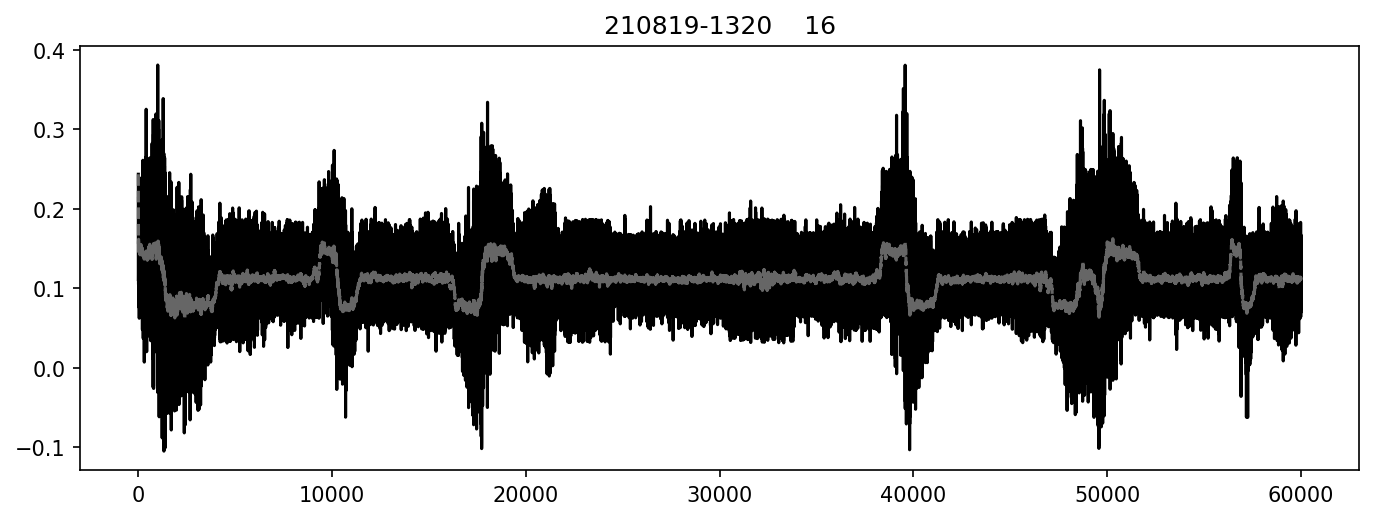

In [201]:
j=16
s=0
e=0


if e ==0: e = 60
s=s*1000
e=e*1000
fig=plt.figure(figsize=(11,3.75),dpi=150)
plt.plot(DataOnlyMatrix[j,s:e].T)
plt.plot(Averages[j,s:e].T)
plt.title(MetaData[j][0]+ '    ' +str(j))
plt.show()

In [97]:
files

['60kAccel-210819-1310.csv',
 '60kPoints-211129-0537-s3.csv',
 '60kPoints-211129-0557-s3.csv',
 '60kPoints-211118-0604-s1.csv',
 '60kAccel-211022-1849.csv',
 '60kGyro-210901-2302.csv',
 '60kPoints-211129-0533-s3.csv',
 '60kPoints-211118-0627-s1.csv',
 '60kPoints-211206-1633-s1.csv',
 '60kAccel-211028-0338.csv',
 '60kPoints-211121-1605-s2.csv',
 '60kGyro-210901-2209.csv',
 '60kAccel-211028-0352.csv',
 '60kAccel-210819-1329.csv',
 '60kAccel-211022-1917.csv',
 '60kAccel-211018-1707.csv',
 '60kAccel-210908-1535.csv',
 '60kAccel-211022-1908.csv',
 '60kAccel-210819-1320.csv',
 '60kAccel-210915-0134.csv',
 '60kPoints-211129-0550-s3.csv',
 '60kAccel-211028-0420.csv',
 '60kAccel-211028-0333.csv',
 '60kAccel-210908-1544.csv',
 '60kAccel-211028-0357.csv',
 '60kAccel-211022-1854.csv',
 '60kPoints-211118-0617-s1.csv',
 '60kAccel-211018-1643.csv',
 '60kPoints-211206-1451-s1.csv',
 '60kGyro-210902-0044.csv',
 '60kAccel-211022-1913.csv',
 '60kAccel-210908-1553.csv',
 '60kAccel-210914-2052.csv',
 '60kG